In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_squared_error
import math
import time

In [2]:
# xls = pd.ExcelFile(r'/data/MGP/TestPoints_20220203_ResFeasible.xlsx')
# df=pd.read_excel(xls,'ResFeasible',header=1).dropna(how='all', axis=1)
# df.drop('#',axis=1,inplace=True)
#pd.to_pickle('../../DataL_Full.pkl')                  
df=pd.read_pickle('../../DataL_Full.pkl')

In [3]:
print(df.shape)
df.head()

(63459, 36)


,Liquid density [kg/m3],Liquid \nviscosity\n [Pa.s],Gas molar mass \n[g/mol],Gas inlet compressibility\n,Hub radius [m],Tip radius [m],Stage 1 [y=1/n=0],Tin [K],Pin [kPa],GVFin,...,Power [kW],Hp [kJ/kg],Axial Power losses [kW],Side wall windage loss [kW],Rotor-diffuser windage [kW],total mechanincal loss [kW],Surge Distance,Total Consumed power,Differential Pressure DeltaP [kPa],Original Order
0,989.321765,0.000558,28.013,0.999146,0.14,0.16,1,322.017877,1867.320507,44.657495,...,194.789217,1.565075,35.354530,9.941665,8.930387,106.731887,3.706551,301.521104,734.557335,1
1,997.303292,0.000839,28.013,0.996045,0.14,0.16,1,300.789449,2261.871734,22.560723,...,29.656316,0.343254,17.295614,1.720538,1.765649,31.377189,14.186424,61.033505,216.501812,2
2,992.909998,0.000611,28.013,1.001839,0.14,0.16,1,316.852547,5056.459294,45.132048,...,48.154779,0.494801,22.269798,2.587538,2.481568,42.433367,24.190271,90.588146,219.724690,4
3,979.249421,0.000400,28.013,1.006971,0.14,0.16,1,344.056608,4641.124807,48.896181,...,68.002181,0.468935,29.328158,5.230348,4.616359,67.117871,58.504924,135.120051,190.069944,5
4,991.458984,0.000593,28.013,0.999425,0.14,0.16,1,318.474477,3259.999596,39.688098,...,195.016966,1.550481,34.631867,10.315960,9.345548,108.934303,2.866052,303.951269,777.200620,7


In [4]:
data=df[['Tin [K]','Pin [kPa]','N [rpm]','Total Consumed power','Differential Pressure DeltaP [kPa]', 'Qin [m3/s]', 'Pout [kPA]', 'GVFin', 'Hp [kJ/kg]', 'GVFout','Qv_out [m3/s]','Surge Distance', 'phi']]

In [5]:
data['Phi_Surge'] = data['phi'] / (1 + data['Surge Distance']/100)

/tmp/ipykernel_3098008/380726293.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Phi_Surge'] = data['phi'] / (1 + data['Surge Distance']/100)


In [6]:
# since this xgb version does not recognise column names with square brackets, commas,\ they need to be replaced with _ 
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
# since this xgb version does not recognise column names with square brackets, commas need to replace the column names.
data.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in data.columns.values]

In [7]:
INPUT_C=['Tin _K_','Pin _kPa_','N _rpm_','Total Consumed power','Differential Pressure DeltaP _kPa_'] #
OUTPUT_C =['GVFin','Qin _m3/s_','GVFout','Qv_out _m3/s_','Phi_Surge'] #,'Hp _kJ/kg_','phi']
X_1=data[INPUT_C]
y_1=data[OUTPUT_C]

In [8]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split

train_X1, test_X1, train_y1, test_y1 = train_test_split(X_1, y_1, train_size=0.8, random_state=32)

In [9]:
train_X1.shape, test_X1.shape, train_y1.shape, test_y1.shape

((50767, 5), (12692, 5), (50767, 5), (12692, 5))

In [10]:
train_y=train_y1.copy() 
test_y=test_y1.copy() 

In [11]:
import time
start_time = time.time()
print(time.asctime( time.localtime(time.time()) ))

# Try a simple XGB model
other_params={'learning_rate':0.1,'n_estimators':300,'max_depth':5,'min_child_weight':1,'subsample':0.8,'colsample_bytree':0.8}
#xgb_regressor=xgb.XGBRegressor(objective='reg:squarederror',**other_params).fit(X,y)
#prediction_all=xgb_regressor.predict(X)
multioutputregressor_1=MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror',**other_params)).fit(train_X1, train_y)

print("--- %s seconds ---" % (time.time() - start_time))

Tue Mar  8 18:29:58 2022
--- 1184.653306722641 seconds ---


In [12]:
predictions_1=multioutputregressor_1.predict(test_X1)

# Get the performance of predictions on all output parameters
print('Root_mean_squared_error_test set_',math.sqrt(mean_squared_error(test_y,predictions_1)))
print('R2 Score_test set_xgb',r2_score(test_y,predictions_1))

Root_mean_squared_error_test set_ 1.9319119681000911
R2 Score_test set_xgb 0.9150224424289434


In [14]:
# Get the performance of predictions_1 on all output parameters
output_c=OUTPUT_C
for i, out in enumerate(output_c):
    print(f'Root_mean_squared_error_test set_{out}', math.sqrt(mean_squared_error(test_y[out],predictions_1[:,i])))
    print(f'R2 Score_test set_xgb_{out}', r2_score(test_y[out],predictions_1[:,i]))
    print('________________________________\n')

Root_mean_squared_error_test set_GVFin 3.1235246922251325
R2 Score_test set_xgb_GVFin 0.9797763061578004
________________________________

Root_mean_squared_error_test set_Qin _m3/s_ 0.005364599306544747
R2 Score_test set_xgb_Qin _m3/s_ 0.9726720440958008
________________________________

Root_mean_squared_error_test set_GVFout 2.984113865231751
R2 Score_test set_xgb_GVFout 0.981198958577509
________________________________

Root_mean_squared_error_test set_Qv_out _m3/s_ 0.005316093852444545
R2 Score_test set_xgb_Qv_out _m3/s_ 0.9694459002628901
________________________________

Root_mean_squared_error_test set_Phi_Surge 0.004489883493140257
R2 Score_test set_xgb_Phi_Surge 0.6720190030507163
________________________________



In [15]:
dfppt=pd.DataFrame(columns=['Variable','RMSE','R²'])
dfppt

,Variable,RMSE,R²


In [16]:
A=[];B=[];C=[]
for i, out in enumerate(output_c):
    A.append(out)
    B.append(round(math.sqrt(mean_squared_error(test_y[out],predictions_1[:,i])),4))
    C.append(round(r2_score(test_y[out],predictions_1[:,i]),4))      

In [17]:
dfppt['Variable']=A
dfppt['RMSE']=B
dfppt['R²']=C

In [18]:
dfppt

,Variable,RMSE,R²
0,GVFin,3.1235,0.9798
1,Qin _m3/s_,0.0054,0.9727
2,GVFout,2.9841,0.9812
3,Qv_out _m3/s_,0.0053,0.9694
4,Phi_Surge,0.0045,0.6720


In [19]:
output_c

['GVFin', 'Qin _m3/s_', 'GVFout', 'Qv_out _m3/s_', 'Phi_Surge']

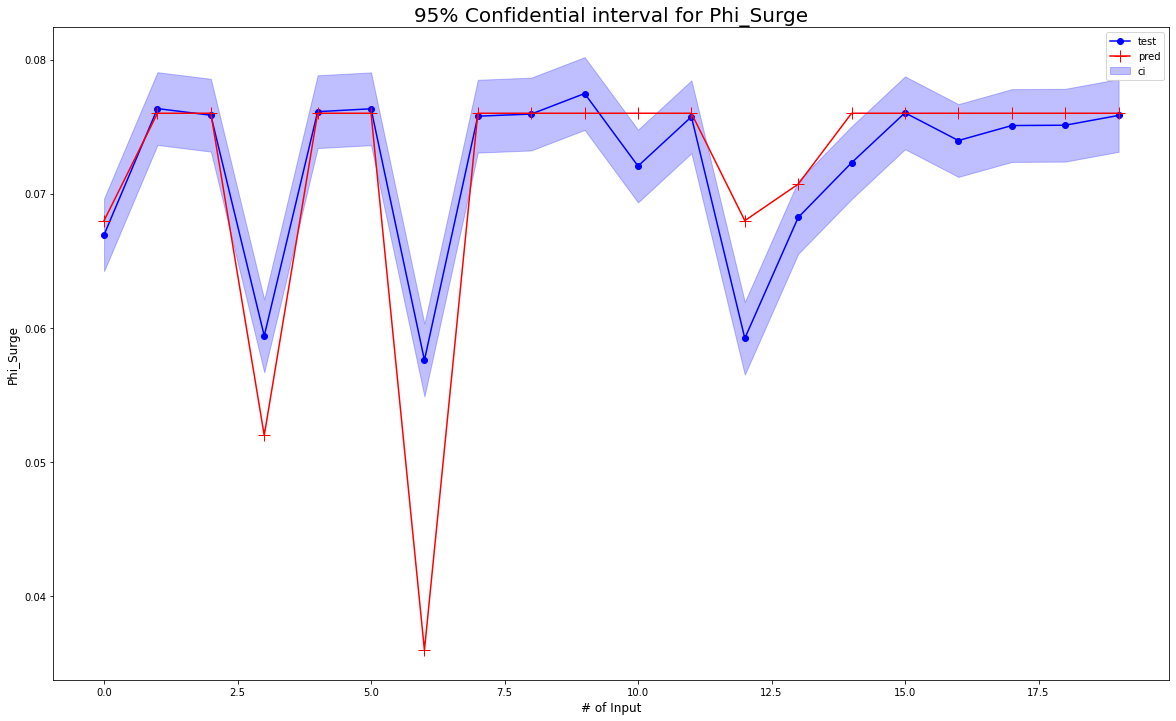

In [23]:
import matplotlib.pyplot as plt

n_points=20
output = 'Phi_Surge'
#output = 'GVFin'
x, pred, y = range(len(predictions_1))[:n_points], test_y1[output][:n_points], predictions_1[:,4][:n_points]

ci = 1.96 * np.std(y)/np.sqrt(len(x))

plt.figure(figsize=(20,12))
plt.plot(x, y, color='b', marker='o', label='test')
plt.plot(x, pred, color='red', marker='+', markersize=12, label='pred')
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.25, label='ci')
plt.title('95%% Confidential interval for %s' %output, fontsize=20)
plt.ylabel(output, fontsize=12)
plt.xlabel('# of Input', fontsize=12)
plt.legend()
plt.show()

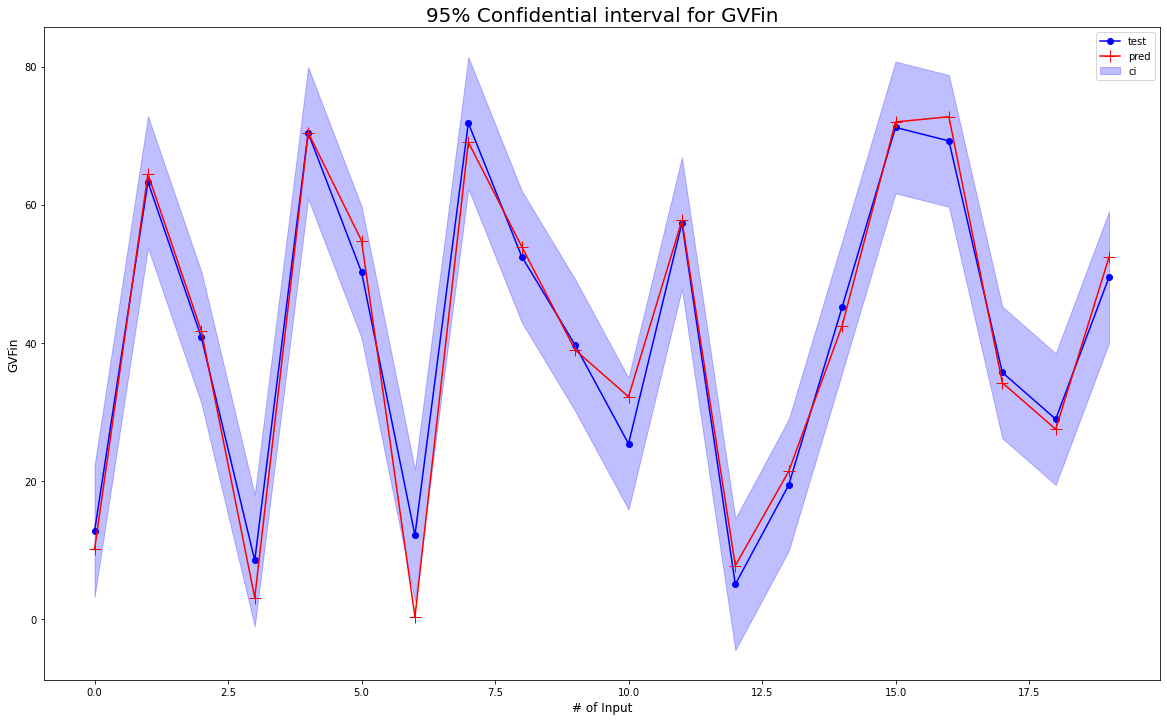

In [22]:
n_points=20
#output = 'Qin _m3/s_'
output = 'GVFin'
x, pred, y = range(len(predictions_1))[:n_points], test_y[output][:n_points], predictions_1[:,0][:n_points]

ci = 1.96 * np.std(y)/np.sqrt(len(x))

plt.figure(figsize=(20,12))
plt.plot(x, y, color='b', marker='o', label='test')
plt.plot(x, pred, color='red', marker='+', markersize=12, label='pred')
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.25, label='ci')
plt.title('95%% Confidential interval for %s' %output, fontsize=20)
plt.ylabel(output, fontsize=12)
plt.xlabel('# of Input', fontsize=12)
plt.legend()
plt.show()

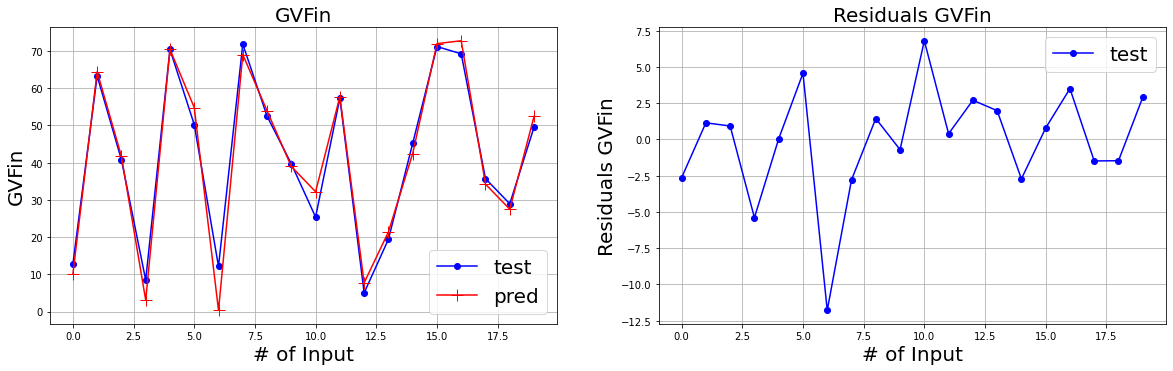

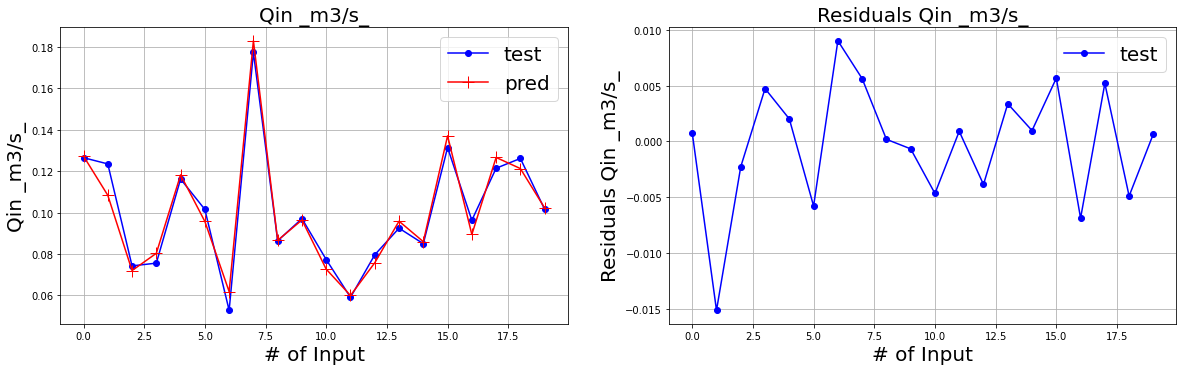

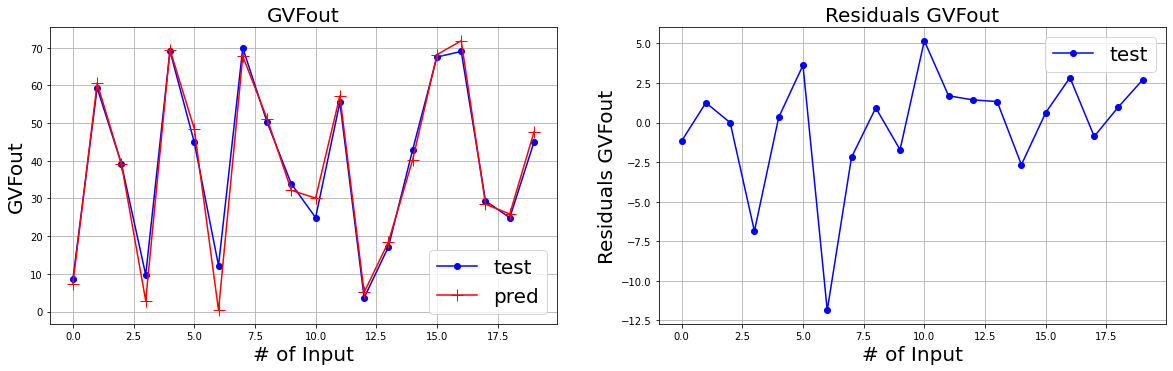

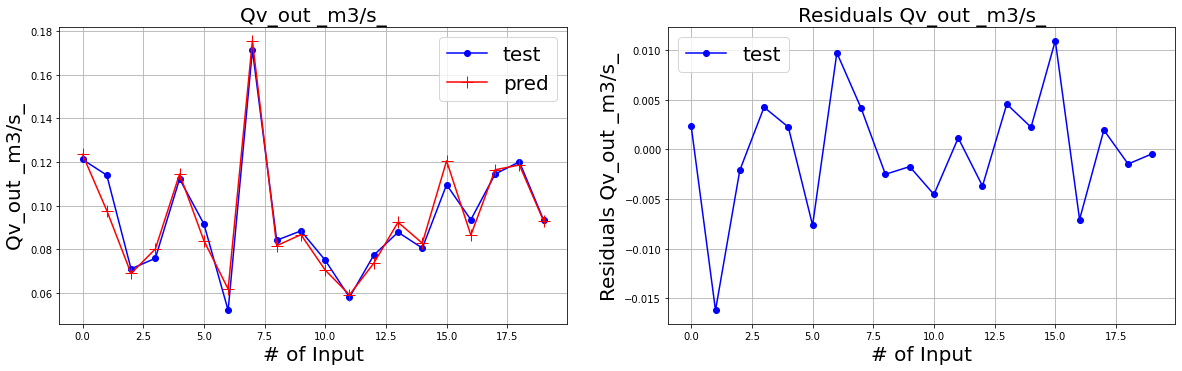

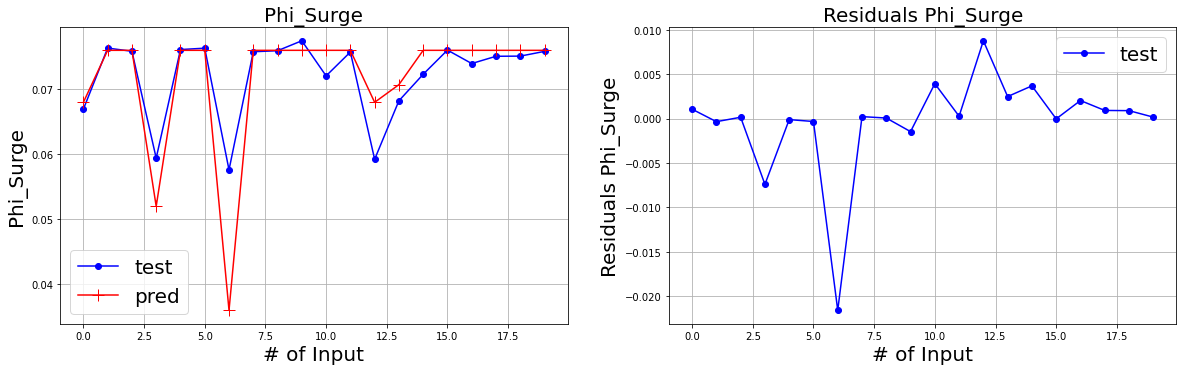

In [24]:
for ii,output in enumerate(output_c):

    x, pred, y = range(len(predictions_1))[:n_points], test_y[output][:n_points], predictions_1[:,ii][:n_points]
    residual = pred - y

    plt.figure(figsize=(20,12))    
    plt.subplot(221)

    plt.plot(x, y, color='b', marker='o', label='test')
    plt.plot(x, pred, color='red', marker='+', markersize=12, label='pred')
    plt.title(output, fontsize=20)
    plt.ylabel(output, fontsize=20)
    plt.xlabel('# of Input', fontsize=20)
    plt.legend(fontsize=20)
    plt.grid(True)

    
    plt.subplot(222)
    plt.plot(x, residual, color='b', marker='o', label='test')
    plt.title('Residuals '+output, fontsize=20)
    plt.ylabel('Residuals '+output, fontsize=20)
    plt.xlabel('# of Input', fontsize=20)
    plt.legend(fontsize=20)
    plt.grid(True)
    
    plt.show()    

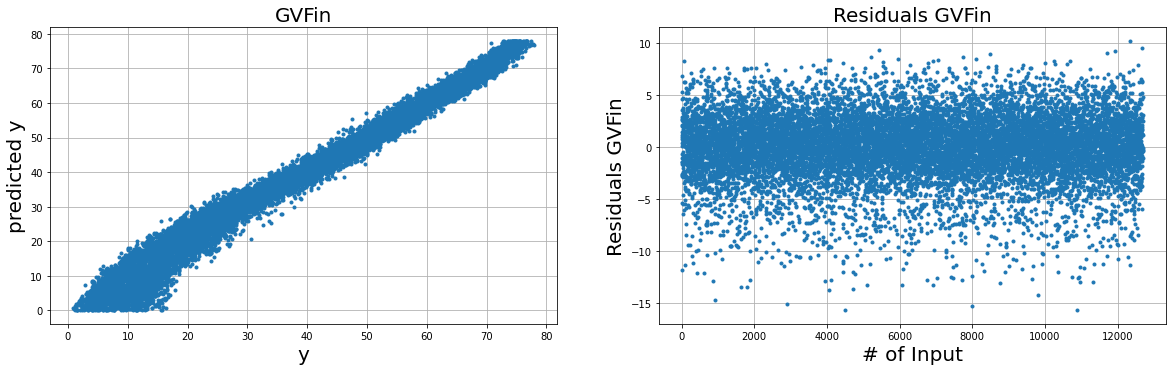

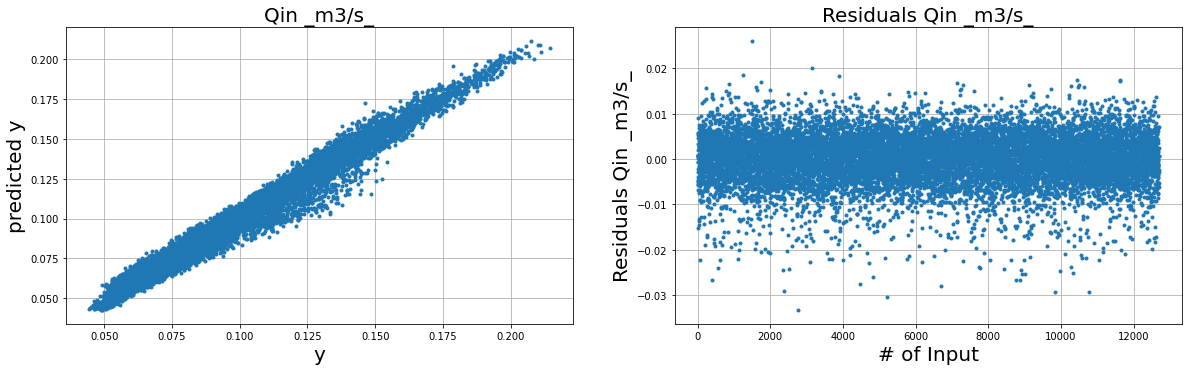

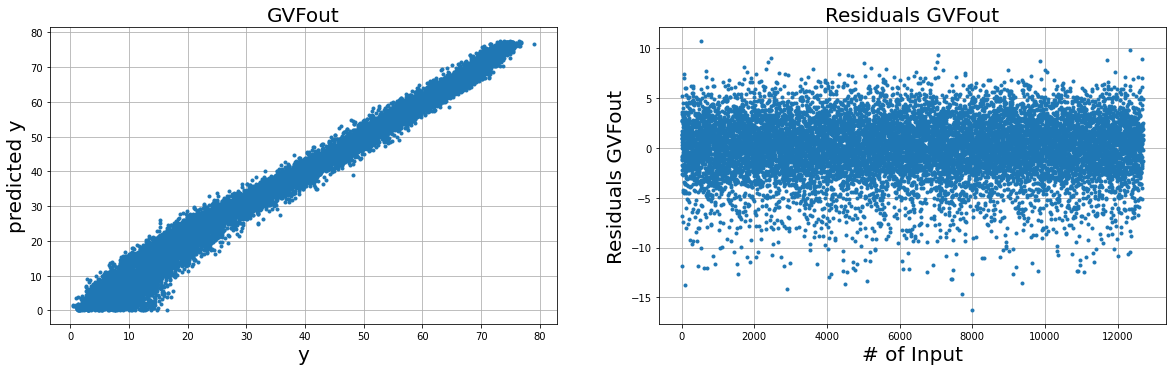

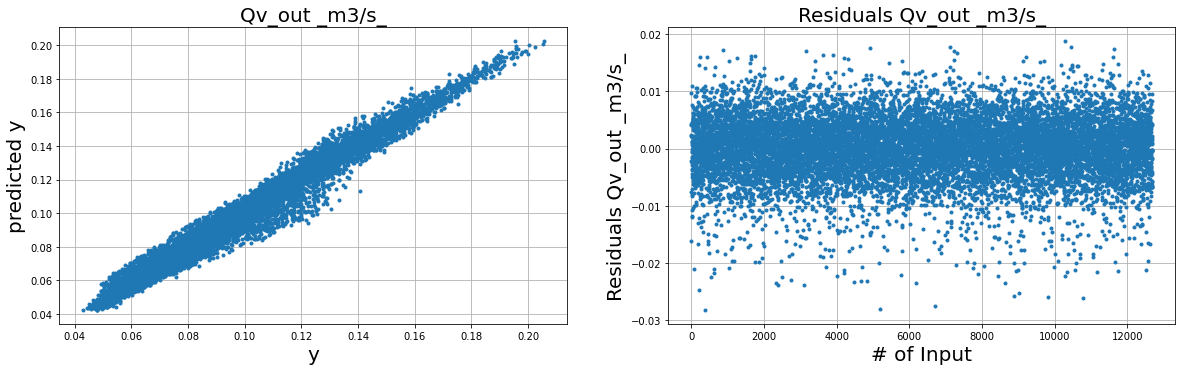

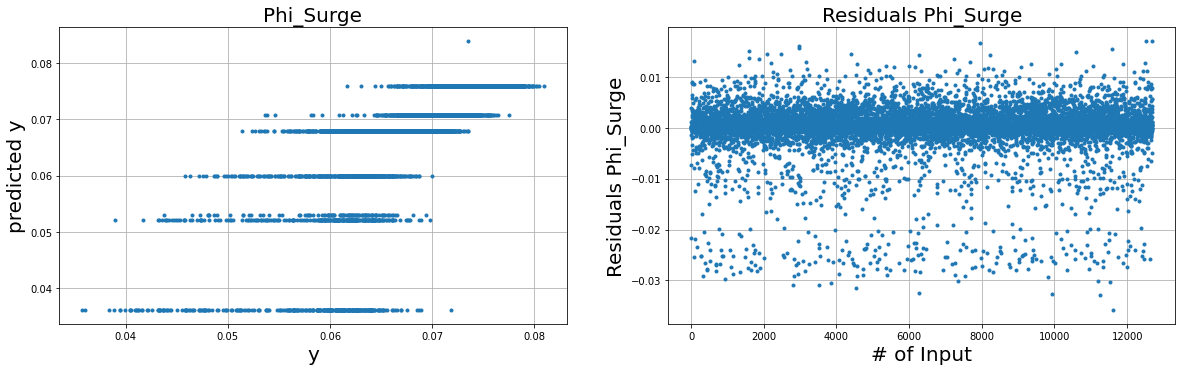

In [25]:
for ii,output in enumerate(output_c):

    x, pred, y = range(len(predictions_1))[:], test_y[output][:], predictions_1[:,ii][:]
    residual = pred - y

    plt.figure(figsize=(20,12))    
    plt.subplot(221)

    plt.plot(y, pred, '.') #color='b', marker='o', label='test')
    plt.title(output, fontsize=20)
    plt.ylabel('predicted y', fontsize=20)
    plt.xlabel('y', fontsize=20)
    #plt.legend(fontsize=20)
    plt.grid(True)

    
    plt.subplot(222)
    plt.plot(x, residual, '.') #color='b', marker='o', label='test')
    plt.title('Residuals '+output, fontsize=20)
    plt.ylabel('Residuals '+output, fontsize=20)
    plt.xlabel('# of Input', fontsize=20)
    #plt.legend(fontsize=20)
    plt.grid(True)
    
    plt.show() 

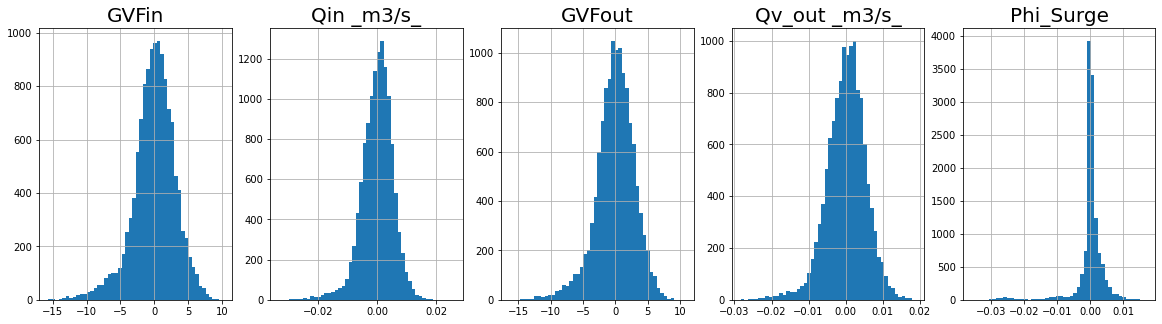

In [28]:
plt.figure(figsize=(20,5)) 
for ii,output in enumerate(output_c):

    x, pred, y = range(len(predictions_1))[:], test_y[output][:], predictions_1[:,ii][:]
    residual = pred - y
   
    plt.subplot(1,5,ii+1)

    plt.hist(residual,bins=50)
    plt.title(output, fontsize=20)
#     plt.ylabel(output, fontsize=20)
#     plt.xlabel('# of Input', fontsize=20)
#     plt.legend(fontsize=20)
    plt.grid(True)
    
    #plt.show() 

In [65]:
dres=pd.DataFrame()
for ii,output in enumerate(output_c):

    x, pred, y = range(len(predictions_1))[:], test_y[output][:], predictions_1[:,ii][:]
    residual = pred - y
    
    dres[output]=residual.describe()
    #print(residual.describe())

In [60]:
dres

,GVFin,Qin _m3/s_,GVFout,Qv_out _m3/s_,Phi_Surge
count,12692.000000,12692.000000,12692.000000,12692.000000,12692.000000
mean,-0.031525,0.000089,-0.018482,0.000108,-0.000061
std,3.123489,0.005364,2.984174,0.005315,0.004490
min,-15.693501,-0.033332,-16.298937,-0.028294,-0.035862
25%,-1.702823,-0.003020,-1.684271,-0.003029,-0.000357
50%,0.148657,0.000475,0.146143,0.000404,0.000164
75%,1.963991,0.003556,1.942452,0.003564,0.001243
max,10.187195,0.026071,10.745019,0.018855,0.017041


In [29]:
data[INPUT_C]

,Tin _K_,Pin _kPa_,N _rpm_,Total Consumed power,Differential Pressure DeltaP _kPa_
0,322.017877,1867.320507,4220.190859,301.521104,734.557335
1,300.789449,2261.871734,2041.082876,61.033505,216.501812
2,316.852547,5056.459294,2638.732515,90.588146,219.724690
3,344.056608,4641.124807,3490.396483,135.120051,190.069944
4,318.474477,3259.999596,4132.563946,303.951269,777.200620
...,...,...,...,...,...
63454,342.844324,3931.572401,2187.733639,60.724971,108.850319
63455,343.324449,3142.194751,4007.911811,326.041463,934.612416
63456,347.624602,3880.621826,2722.006086,111.829845,372.735826
63457,322.756787,1772.036814,3732.260937,152.427097,213.344204


In [30]:
#for ii,output in enumerate(output_c):
    #data[output+'_pred'] 
A = multioutputregressor_1.predict(data[INPUT_C])

In [31]:
A[:,i]

array([0.07744475, 0.06582666, 0.07550811, ..., 0.07096267, 0.07601907,
       0.07531193], dtype=float32)

In [32]:
for i, out in enumerate(output_c):
    data[out+'_pred'] = A[:,i]

/tmp/ipykernel_3098008/212872644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[out+'_pred'] = A[:,i]


In [34]:
import math
data['Phi_pred']=data['Qin _m3/s__pred']/(data['N _rpm_']/60*2*math.pi*0.15*0.01885)

/tmp/ipykernel_3098008/4076675408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Phi_pred']=data['Qin _m3/s__pred']/(data['N _rpm_']/60*2*math.pi*0.15*0.01885)


In [35]:
Phi_surge=0.076
data['Surge Distance_pred'] = 100*(data['Phi_pred']-Phi_surge)/Phi_surge 

/tmp/ipykernel_3098008/3477137286.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Surge Distance_pred'] = 100*(data['Phi_pred']-Phi_surge)/Phi_surge


In [37]:
data.to_pickle('data_w_pred.pkl')

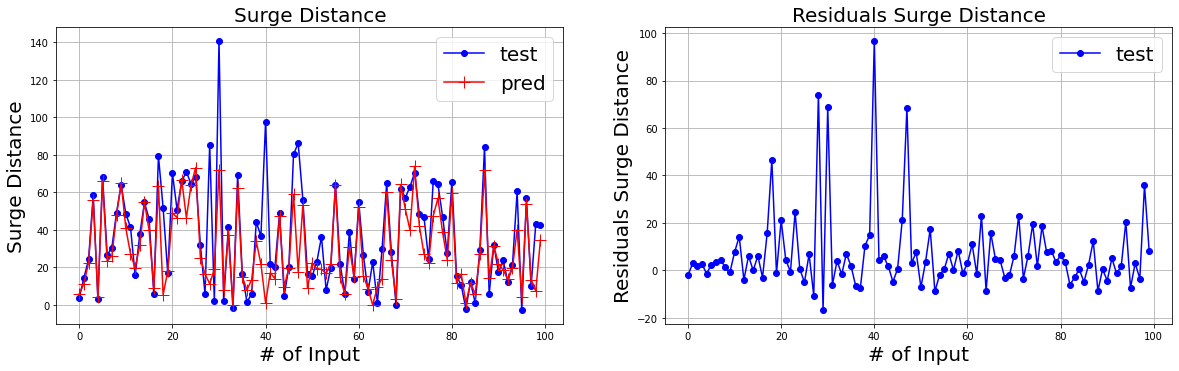

In [38]:
#for ii,output in enumerate(output_c):
output = 'Surge Distance'
data1=data.head(100)

# x, pred, y = range(len(predictions_1))[:n_points], test_y[output][:n_points], predictions_1[:,ii][:n_points]
# residual = pred - y

plt.figure(figsize=(20,12))    
plt.subplot(221)

plt.plot(data1.index, data1['Surge Distance'], color='b', marker='o', label='test')
plt.plot(data1.index, data1['Surge Distance_pred'], color='red', marker='+', markersize=12, label='pred')
plt.title(output, fontsize=20)
plt.ylabel(output, fontsize=20)
plt.xlabel('# of Input', fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)


plt.subplot(222)
#plt.figure(figsize=(10,6))
plt.plot(data1.index, data1['Surge Distance']-data1['Surge Distance_pred'], color='b', marker='o', label='test')
plt.title('Residuals '+output, fontsize=20)
plt.ylabel('Residuals '+output, fontsize=20)
plt.xlabel('# of Input', fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)

plt.show()

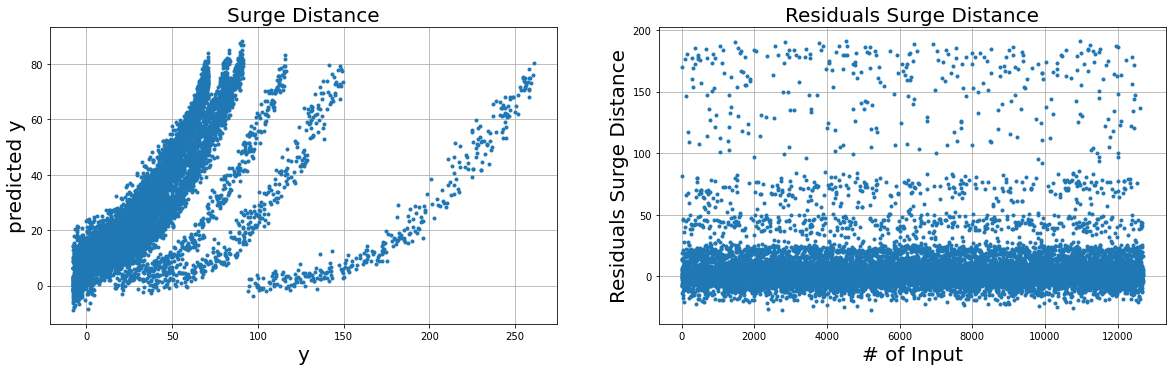

In [89]:
#for ii,output in enumerate(output_c):
output = 'Surge Distance'

data1=data.iloc[test_y1.index] #head(100)

# x, pred, y = range(len(predictions_1))[:n_points], test_y[output][:n_points], predictions_1[:,ii][:n_points]
# residual = pred - y

plt.figure(figsize=(20,12))    
plt.subplot(221)

plt.plot(data1['Surge Distance'], data1['Surge Distance_pred'], '.') #color='b', marker='o', label='test')
plt.title(output, fontsize=20)
plt.ylabel('predicted y', fontsize=20)
plt.xlabel('y', fontsize=20)
plt.grid(True)


plt.subplot(222)
#plt.figure(figsize=(10,6))
plt.plot(np.linspace(0,len(data1.index),len(data1.index)), data1['Surge Distance']-data1['Surge Distance_pred'], '.') #color='b', marker='o', label='test')
plt.title('Residuals '+output, fontsize=20)
plt.ylabel('Residuals '+output, fontsize=20)
plt.xlabel('# of Input', fontsize=20)
plt.grid(True)

plt.show()

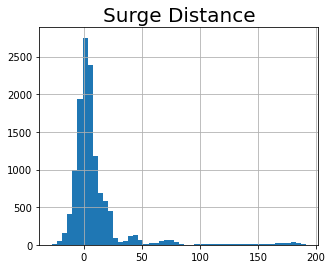

In [90]:
plt.figure(figsize=(5,4)) 

output = 'Surge Distance'

plt.hist(data1['Surge Distance']-data1['Surge Distance_pred'],bins=50)
plt.title(output, fontsize=20)
#     plt.ylabel(output, fontsize=20)
#     plt.xlabel('# of Input', fontsize=20)
#     plt.legend(fontsize=20)
plt.grid(True)
    
#plt.show() 

In [41]:
data.columns

Index(['Tin _K_', 'Pin _kPa_', 'N _rpm_', 'Total Consumed power',
       'Differential Pressure DeltaP _kPa_', 'Qin _m3/s_', 'Pout _kPA_',
       'GVFin', 'Hp _kJ/kg_', 'GVFout', 'Qv_out _m3/s_', 'Surge Distance',
       'phi', 'Phi_Surge', 'GVFin_pred', 'Qin _m3/s__pred', 'GVFout_pred',
       'Qv_out _m3/s__pred', 'Phi_Surge_pred', 'Phi_pred',
       'Surge Distance_pred'],
      dtype='object')

In [99]:
output_c2=['Surge Distance']
for i, out in enumerate(output_c2):
    print(f'RMSE_test set_{out}', math.sqrt(mean_squared_error(data[out],data[out+'_pred'])))
    print(f'R2 Score_test set_xgb_{out}', r2_score(data[out],data[out+'_pred']))
    print('________________________________\n')

RMSE_test set_Surge Distance 28.821623795243752
R2 Score_test set_xgb_Surge Distance 0.34113228241351523
________________________________



In [43]:
data.columns

Index(['Tin _K_', 'Pin _kPa_', 'N _rpm_', 'Total Consumed power',
       'Differential Pressure DeltaP _kPa_', 'Qin _m3/s_', 'Pout _kPA_',
       'GVFin', 'Hp _kJ/kg_', 'GVFout', 'Qv_out _m3/s_', 'Surge Distance',
       'phi', 'Phi_Surge', 'GVFin_pred', 'Qin _m3/s__pred', 'GVFout_pred',
       'Qv_out _m3/s__pred', 'Phi_Surge_pred', 'Phi_pred',
       'Surge Distance_pred'],
      dtype='object')

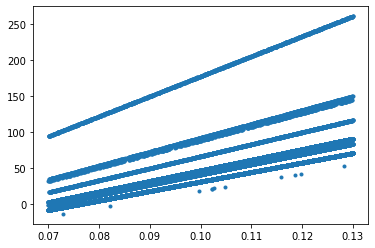

In [44]:
plt.plot(data['phi'],data['Surge Distance'],'.')

In [74]:
data1=data.copy()

In [75]:
data1['res_surge']=data1['Surge Distance']-data1['Surge Distance_pred']

In [76]:
data1['abs_res_surge']=abs(data1['res_surge'])

In [77]:
data1['res_surge'].describe()

count    63459.000000
mean         9.567358
std         27.187558
min        -27.462539
25%         -1.776334
50%          2.958957
75%          9.927167
max        191.898826
Name: res_surge, dtype: float64

In [78]:
data3=data1.loc[test_y1.index]

In [79]:
data3

,Tin _K_,Pin _kPa_,N _rpm_,Total Consumed power,Differential Pressure DeltaP _kPa_,Qin _m3/s_,Pout _kPA_,GVFin,Hp _kJ/kg_,GVFout,...,GVFin_pred,Qin _m3/s__pred,GVFout_pred,Qv_out _m3/s__pred,Phi_Surge_pred,Phi_pred,Surge Distance_pred,Surge Distance_pred_w_Phi_surge_data,res_surge,abs_res_surge
47218,298.048477,1297.278246,3699.574381,269.249745,541.728978,0.127281,1839.007223,10.086842,0.723822,7.333393,...,12.724312,0.126504,8.500325,0.121179,0.066943,0.115484,51.952388,69.833141,18.924061,18.924061
37512,339.697479,3615.279849,5036.761476,319.818851,647.199065,0.108380,4262.478914,64.449400,2.166166,60.593139,...,63.303547,0.123513,59.341747,0.113971,0.076346,0.082819,8.971958,8.974525,-13.349208,13.349208
32634,326.671454,3599.246149,3130.685084,141.149601,405.624802,0.072017,4004.870950,41.713134,0.860291,39.141989,...,40.787552,0.074274,39.146137,0.071081,0.075852,0.080124,5.426639,5.429123,-3.200068,3.200068
56682,305.079339,2617.228559,2281.770780,79.109624,198.906355,0.080353,2816.134914,3.085957,0.248867,2.874257,...,8.480118,0.075611,9.734777,0.075920,0.059415,0.111914,47.254896,115.223764,81.464671,81.464671
56452,352.332356,2944.697626,3738.003612,106.316127,137.467894,0.118230,3082.165520,70.455885,0.583708,69.497368,...,70.412491,0.116207,69.172028,0.112255,0.076116,0.104994,38.149510,38.152765,2.407297,2.407297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63195,337.948261,1002.620943,3812.721699,317.664055,1023.279640,0.086653,2025.900582,8.100624,1.344560,4.180041,...,5.599001,0.089539,2.914443,0.088825,0.053676,0.079313,4.359697,12.156279,4.181105,4.181105
24661,309.165489,5770.389696,3229.075750,205.122644,684.505573,0.071562,6454.895270,14.072344,0.966103,12.770626,...,11.053507,0.077782,10.277509,0.077270,0.064881,0.081352,7.042356,19.638393,3.028838,3.028838
61528,338.936042,4824.365796,3154.171645,183.257964,597.680711,0.082280,5422.046507,11.898444,0.835599,10.727561,...,11.959344,0.079933,10.933320,0.080307,0.062338,0.085587,12.614701,25.866455,16.948177,16.948177
23080,306.044954,5716.565046,4944.342311,250.152351,393.699320,0.151241,6110.264366,70.824605,1.516550,69.429552,...,71.913734,0.144149,70.738586,0.140285,0.076202,0.098463,29.556027,29.559080,6.377257,6.377257


In [80]:
data3['res_surge'].describe()

count    12692.000000
mean         9.713618
std         27.789572
min        -27.462539
25%         -1.981824
50%          3.190282
75%         10.300365
max        191.183580
Name: res_surge, dtype: float64

In [53]:
data['Phi_Surge'] = data['phi'] / (1 + data['Surge Distance']/100)

/tmp/ipykernel_3098008/380726293.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Phi_Surge'] = data['phi'] / (1 + data['Surge Distance']/100)


In [55]:
data['Surge Distance_pred_w_Phi_surge_data'] = 100*(data['Phi_pred']-data['Phi_Surge'])/data['Phi_Surge'] 

/tmp/ipykernel_3098008/2692266409.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Surge Distance_pred_w_Phi_surge_data'] = 100*(data['Phi_pred']-data['Phi_Surge'])/data['Phi_Surge']


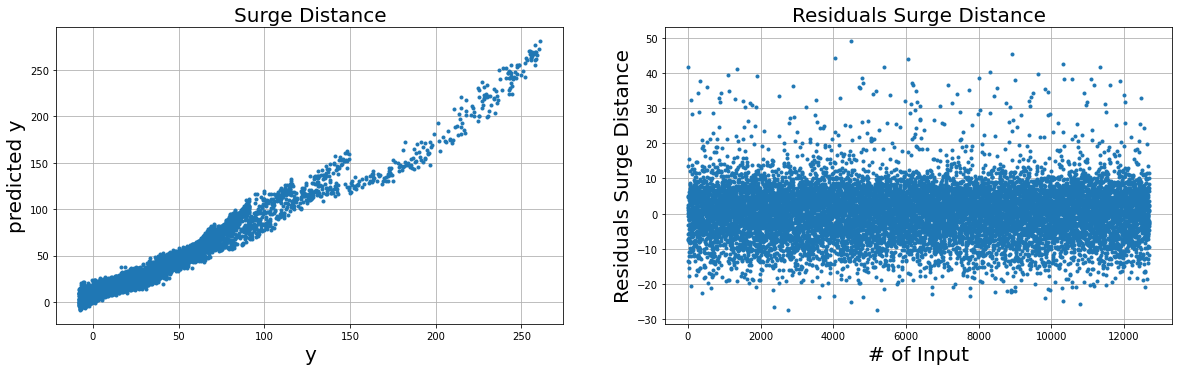

In [92]:
output = 'Surge Distance'

data1=data.iloc[test_y1.index] #head(100)

# x, pred, y = range(len(predictions_1))[:n_points], test_y[output][:n_points], predictions_1[:,ii][:n_points]
# residual = pred - y

plt.figure(figsize=(20,12))    
plt.subplot(221)

plt.plot(data1['Surge Distance'], data1['Surge Distance_pred_w_Phi_surge_data'], '.') #color='b', marker='o', label='test')
plt.title(output, fontsize=20)
plt.ylabel('predicted y', fontsize=20)
plt.xlabel('y', fontsize=20)
plt.grid(True)


plt.subplot(222)
#plt.figure(figsize=(10,6))
plt.plot(np.linspace(0,len(data1.index),len(data1.index)), data1['Surge Distance']-data1['Surge Distance_pred_w_Phi_surge_data'], '.') #color='b', marker='o', label='test')
plt.title('Residuals '+output, fontsize=20)
plt.ylabel('Residuals '+output, fontsize=20)
plt.xlabel('# of Input', fontsize=20)
plt.grid(True)

plt.show()

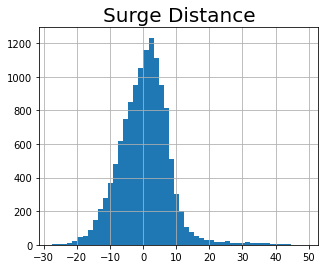

In [94]:
plt.figure(figsize=(5,4)) 

output = 'Surge Distance'

plt.hist(data1['Surge Distance']-data1['Surge Distance_pred_w_Phi_surge_data'],bins=50)
plt.title(output, fontsize=20)
plt.grid(True)

In [95]:
dres2=data1['Surge Distance']-data1['Surge Distance_pred_w_Phi_surge_data']

In [96]:
dres2.describe()

count    12692.000000
mean         0.390834
std          7.554904
min        -27.465379
25%         -4.312793
50%          0.662144
75%          4.831776
max         49.141910
dtype: float64

In [98]:
output_c2=['Surge Distance']
for i, out in enumerate(output_c2):
    print(f'RMSE_test set_{out}', math.sqrt(mean_squared_error(data1[out],data1[out+'_pred_w_Phi_surge_data'])))
    print(f'R2 Score_test set_xgb_{out}', r2_score(data1[out],data1[out+'_pred_w_Phi_surge_data']))
    print('________________________________\n')

RMSE_test set_Surge Distance 7.564709185132676
R2 Score_test set_xgb_Surge Distance 0.9550213709263812
________________________________

